In [1]:
suppressPackageStartupMessages({
    library(stringr)
    library(ggplot2)
    library(dplyr)
    library(reshape2)
})

theme_set(theme_minimal())
theme_update(text = element_text(size = 17))

In [2]:
anno_pep = read.table("../data/PhageScan_PeptideAnno.tsv", header = TRUE, sep = "\t", stringsAsFactors=FALSE)
lfc_org = read.table("../data/PhageScan_peptide_logHFC.csv", sep = ",")
phar = read.table("../data/PhARscores_dolphyn_pepsyn.csv", sep = ",", header = TRUE,  stringsAsFactors=FALSE)

In [3]:
phar %>% subset(library == "pepsyn") %>% 
group_by(sample) %>% summarise_at(vars(vir_score), list(max = max)) %>%
arrange(desc(max)) %>% head(4) %>% select(sample) %>% unique -> top_score_sample
top_score_sample[[1]] -> top_score_sample

In [4]:
top_score_sample

[1] "S3.0693.01X195"   "S3.0153.01X194"   "SO.0491.01X194"   "S3.0693.01.2X194"

In [5]:
anno_pep %>% 
select(pep_id, tile_id, sublibrary,pep_aa) %>% subset(sublibrary == "dolphyn") %>%
mutate(pep1 = str_split(pep_aa, "GGGGS", simplify=TRUE)[,1])%>%
mutate(pep2 = str_split(pep_aa, "GGGGS", simplify=TRUE)[,2])%>%
mutate(pep3 = gsub("\\*","",str_split(pep_aa, "GGGGS", simplify=TRUE)[,3],)) %>%
melt(id.vars = c("pep_id","sublibrary","pep_aa"), value.name = "sub_aa", variable.name = "pep_no") %>%
merge(anno_pep %>% subset(sublibrary == "dolphynepitopes") %>% mutate(pep_aa = str_sub(pep_aa,6,20)) %>% select(pep_id,pep_aa),
      by.x="sub_aa", by.y = "pep_aa") -> dol_epi_map

In [6]:
rbind(dol_epi_map %>% select(pep_id.x) %>% unique() %>% rename(triplet_id = pep_id.x) %>% mutate(pep_id = triplet_id) %>% mutate(pep_no = "triplet"),
      dol_epi_map %>% select(pep_id.y, pep_id.x, pep_no) %>% rename(pep_id = pep_id.y) %>% rename(triplet_id = pep_id.x)) -> dol_epi_map

In [7]:
lfc_org %>% select(all_of(top_score_sample)) %>% tibble::rownames_to_column("tile_id") %>% 
melt(id.vars = "tile_id", value.name="lfc", variable.name = "sample") -> tdf
anno_pep %>% select(c("sublibrary", "pro_id", "pep_id", "tile_id", "taxon_id")) %>% 
subset(sublibrary != "pepsyn") %>% 
merge(tdf) %>% mutate(across(where(is.factor), as.character)) -> tdf 

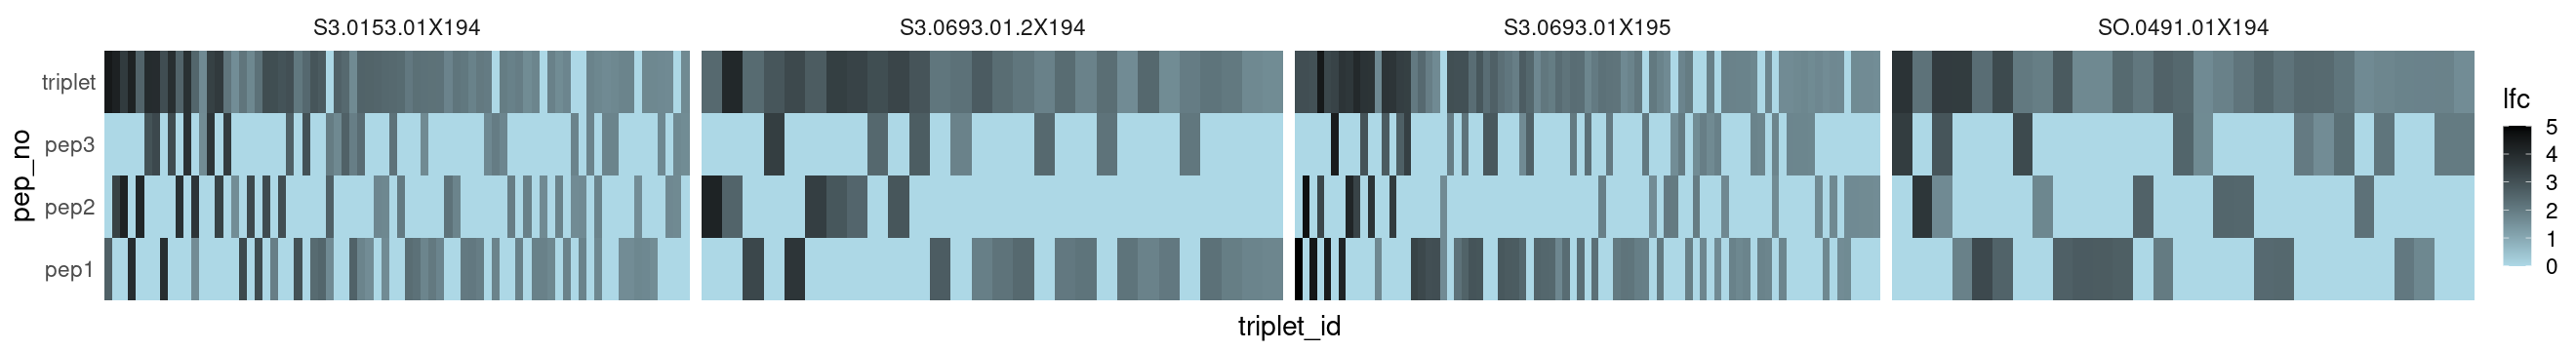

In [8]:
options(repr.plot.width=22, repr.plot.height=3)

merge(dol_epi_map,tdf) %>% mutate(tripletSample = paste(triplet_id,sample)) %>% 
select(taxon_id,pro_id,lfc,pep_no,tripletSample) %>%
mutate(lfc_bin = lfc >0) %>%
group_by(tripletSample) %>% summarise_at(vars(lfc_bin), list(sum=sum)) %>%
subset(sum>1) %>% select(tripletSample) %>% unlist() -> positive_triplets

merge(dol_epi_map,tdf) %>% mutate(tripletSample = paste(triplet_id,sample)) %>% 
select(taxon_id,pro_id,lfc,pep_no,triplet_id,tripletSample, sample) %>%
subset(tripletSample %in% positive_triplets) %>% 
mutate(lfc_bin = lfc >0) %>%
arrange(desc(lfc_bin), desc(lfc)) %>% 
mutate(triplet_id = factor(triplet_id, levels = unique(triplet_id))) %>%

ggplot(aes(triplet_id,pep_no)) + geom_tile(aes(fill = lfc)) + scale_fill_gradient(low = "lightblue", high = "black") + 
theme(axis.text.x=element_blank(), panel.grid.major.x = element_blank(), panel.grid.major.y = element_blank()) +
facet_grid(.~sample, scales= "free")

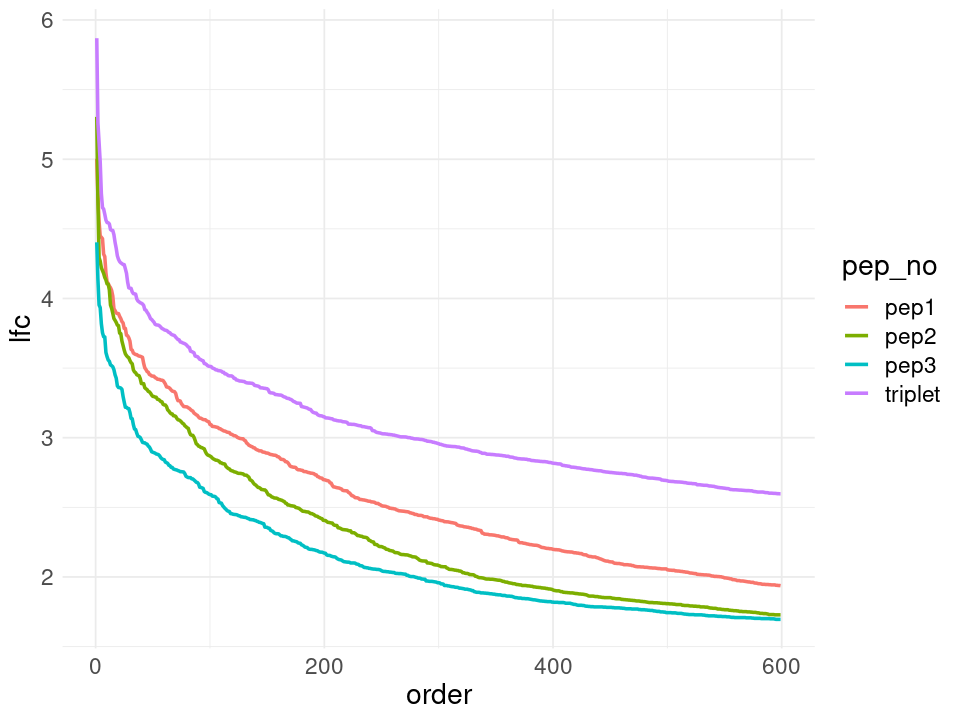

In [9]:
options(repr.plot.width=8, repr.plot.height=6)

lfc_org %>% tibble::rownames_to_column("tile_id") %>%
merge(anno_pep %>% select(c("sublibrary", "pro_id", "pep_id", "tile_id", "taxon_id"))) %>%
subset(sublibrary != "pepsyn") %>% merge(dol_epi_map) %>% 
melt(id.vars = c("sublibrary", "pro_id", "pep_id", "taxon_id","tile_id","triplet_id","pep_no"), value.name="lfc", variable.name = "sample") %>% 
mutate(tripletSample = paste(triplet_id,sample)) %>% 

subset(lfc>0) %>% 
arrange(desc(lfc)) %>% group_by(pep_no) %>% mutate(order = row_number()) %>%
subset(order < 600) %>%

ggplot(aes(order, lfc, color = pep_no)) + geom_line(size = 1)